# Video Classification using H2O's AutoML


In this notebook, we'll explore how to preprocess video data, extract features, and use H2O's AutoML for classification.


In [24]:
!pip install h2o

In [25]:
!unzip HAR

Archive:  HAR.zip
replace HAR/eat/20060723sfjffdabaum_eat_h_cm_np1_fr_goo_0.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Importing Necessary Libraries

In [26]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML


## Data Exploration and Visualization

In [27]:
# List the files in the 'eat' and 'fall_floor' directories
eat_files = os.listdir("/content/HAR/eat")
fall_floor_files = os.listdir("/content/HAR/fall_floor")

eat_files_count = len(eat_files)
fall_floor_files_count = len(fall_floor_files)

eat_files_count, fall_floor_files_count



(108, 136)

In [28]:
# Check the first few file extensions in both categories
eat_file_types = set([os.path.splitext(file)[1] for file in eat_files])
fall_floor_file_types = set([os.path.splitext(file)[1] for file in fall_floor_files])

eat_file_types, fall_floor_file_types


({'.avi'}, {'.avi'})

## Feature Extraction

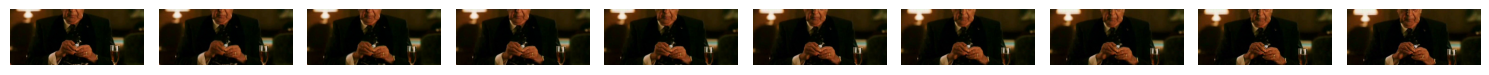

In [29]:
import cv2
import matplotlib.pyplot as plt

# Load a sample video from the 'eat' category
sample_video_path = os.path.join("/content/HAR/eat", eat_files[0])
cap = cv2.VideoCapture(sample_video_path)

# Extract a few frames from the video
frames = []
for i in range(10):
    ret, frame = cap.read()
    if ret:
        # Convert the frame from BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

# Close the video file
cap.release()

# Display the extracted frames
fig, axs = plt.subplots(1, len(frames), figsize=(15, 5))
for ax, frm in zip(axs, frames):
    ax.imshow(frm)
    ax.axis('off')

plt.tight_layout()
plt.show()


## Preparing Data for H2O

In [30]:
import numpy as np

def extract_video_features(video_path, frame_size=(64, 64), frames_to_extract=10):
    """
    Extract features from a video.

    Parameters:
    - video_path: Path to the video file.
    - frame_size: Size to which each frame will be resized.
    - frames_to_extract: Number of frames to extract from the video.

    Returns:
    - A flattened numpy array containing features of the video.
    """
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = frame_count // frames_to_extract

    features = []

    for i in range(frames_to_extract):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if ret:
            resized_frame = cv2.resize(frame, frame_size)
            features.append(resized_frame)

    cap.release()

    # Average the features across all frames and flatten
    averaged_features = np.mean(features, axis=0).flatten()

    return averaged_features

# Extract features for a subset of videos from both categories
num_samples = 10  # For demonstration purposes, we'll only use a subset
eat_features = [extract_video_features(os.path.join("/content/HAR/eat", file)) for file in eat_files[:num_samples]]
fall_floor_features = [extract_video_features(os.path.join("/content/HAR/fall_floor", file)) for file in fall_floor_files[:num_samples]]

len(eat_features), len(fall_floor_features)


(10, 10)

In [31]:
from sklearn.model_selection import train_test_split

# Combine features and create labels
X = eat_features + fall_floor_features
y = [0] * len(eat_features) + [1] * len(fall_floor_features)  # 0 for 'eat' and 1 for 'fall_floor'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test)



(16, 4)

In [32]:
X_train[0]

array([30.2, 43.9, 36.1, ...,  3. ,  5. ,  6.6])

## Using H2O's AutoML

In [33]:

import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Initialize the H2O cluster
h2o.init()

# Convert the dataset into H2OFrame
hf_train = h2o.H2OFrame(pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name='label')], axis=1))
hf_test = h2o.H2OFrame(pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name='label')], axis=1))

# Specify the response column
response = "label"


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,8 mins 34 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_vcgctp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
# Run AutoML
aml = H2OAutoML(max_models=1, seed=42, max_runtime_secs=600)
aml.train(y=response, training_frame=hf_train)



AutoML progress: |
01:21:53.623: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20231101_12151


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.2504863034084792
RMSE: 0.5004860671472077
MAE: 0.5
RMSLE: 0.34936567543611585
Mean Residual Deviance: 0.2504863034084792

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.2778425355366398
RMSE: 0.5271077077188682
MAE: 0.5243861433118582
RMSLE: 0.3687513358011127
Mean Residual Deviance: 0.2778425355366398

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.526012  0.0550623  0.5           0.492712      0.517396      0.496885      0.623065
mean_residual_deviance  0.279699  0.0615476  0.25          0.24319       0.27012       0.246973      0.38821
mse                     0.279699  0.0615476  0.25          0.24319       0.27012       0.246973      0.38821
r2                      -inf      nan        -0.333333     -0.0943561    -0.21554      -0.111377     -inf
residual_deviance       0.279699  0.0615476  0.25          0.24319       0.27012       0.246973      0.38821
rmse                    0.526581  0.0549044  0.5           0.493143      0.519731      0.496964      0.623065
rmsle                   0.367474  0.0225297  0.379462      0.329462      0.387671      0.367488      0.373287

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-11-01 01:22:29  35.514 sec  0                  0.5              0.5             0.25
    2023-11-01 01:22:29  36.030 sec  5                  0.500012         0.5             0.250012
    2023-11-01 01:22:29  36.128 sec  10                 0.500297         0.5             0.250297
    2023-11-01 01:22:29  36.226 sec  15                 0.500176         0.5             0.250176
    2023-11-01 01:22:30  36.398 sec  20                 0.501517         0.5             0.251519
    2023-11-01 01:22:30  36.479 sec  25                 0.500018         0.5             0.250018
    2023-11-01 01:22:30  36.567 sec  30                 0.500486         0.5             0.250486

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [35]:
# Get the leaderboard
lb = aml.leaderboard

In [36]:
# Predict on test set
preds = aml.leader.predict(hf_test)
preds

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict
0.477948
0.477948
0.477948
0.477948


In [37]:

# Shutdown the H2O cluster
h2o.cluster().shutdown()

H2O session _sid_b0e4 closed.
